In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import warnings
warnings.filterwarnings('ignore')

# Task 1 - Non-linear linear regression model

In [2]:
# Step 1 - generation of our data

def generate_data(n_data):
    x = np.random.uniform(0.1, 10, n_data)
    x = np.sort(x)

    y_clean = (np.log(x) + 1) * np.cos(x) + np.sin(2 * x)
    noise = np.random.randn(n_data)
    y_noisy = y_clean + noise

    return y_clean, y_noisy, x

In [3]:
n_data = 100
y_clean, y_noisy, x = generate_data(100)

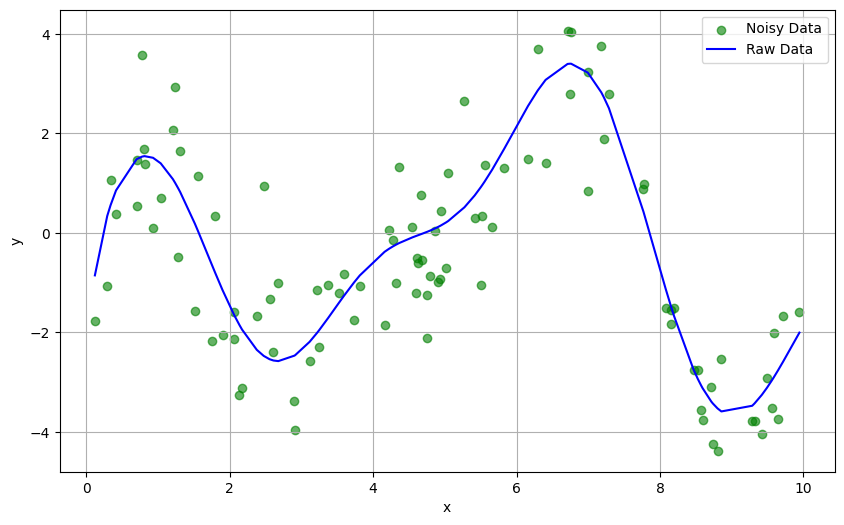

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y_noisy, alpha=0.6, label="Noisy Data", color="green")
plt.plot(x, y_clean, label="Raw Data", color="blue")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

I will use the code that was on tutorial


Tutorial code

In [5]:
class GradientDescent:
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []

    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)
            w = w - self.learning_rate * grad
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w

class LinearRegression:
    def __init__(self, add_bias=True, l2_reg=0,  l1_reg = 0):
        self.add_bias = add_bias
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.w = None

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]                         #add a dimension for the features
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x, np.ones(N)])    #add bias by adding a constant feature of value 1
        self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference
        return self

    def fit_lasso(self, x, y, max_iter=1000, tol=1e-6):
        if x.ndim == 1:
            x = x[:, None]
        y = np.asarray(y).ravel()
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
        N, D = x.shape

        def soft_threshold(z, lam):
            if z > lam:
                return z - lam
            if z < -lam:
                return z + lam
            return 0.0

        w0 = np.zeros(D)
        w = w0.copy()
        y_hat = x @ w
        denom = (x * x).sum(axis=0) / N

        for _ in range(max_iter):
            w_old = w.copy()
            for j in range(D):
                xj = x[:, j]
                r = y - (y_hat - xj * w[j])
                beta = (xj @ r) / N
                if denom[j] > 0.0:
                    # do NOT penalize intercept (last column) if bias added
                    if self.add_bias and j == D - 1:
                        w[j] = beta / denom[j]
                    else:
                        w[j] = soft_threshold(beta, self.l1_reg) / denom[j]
                else:
                    w[j] = 0.0
                y_hat = x @ w

            if np.linalg.norm(w - w_old, ord=np.inf) <= tol:
                break

        self.w = w
        return self

    def fit_ridge(self, x, y, optimizer):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        def gradient(x, y, w):
            yh =  x @ w
            N, D = x.shape
            grad = .5*np.dot(yh - y, x)/N
            grad += self.l2_reg* w
            return grad
        w0 = np.zeros(D)
        self.w = optimizer.run(gradient, x, y, w0)
        return self

    def predict(self, x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w                             #predict the y values
        return yh


In [45]:
model = LinearRegression()

In [46]:
x_min, x_max = float(np.min(x)), float(np.max(x))
sigma = 1.0

In [47]:
def gaussian_phi(x_local, D) -> np.ndarray:
    if D == 0:
        return np.empty((x_local.shape[0], 0))
    mu = np.linspace(x_min, x_max, D)
    return np.exp(-((x_local[:, None] - mu[None, :]) / sigma) ** 2)

def fit_num_bases(D: int, x_local, y_train) -> np.ndarray:
    phi = gaussian_phi(x_local, D)
    yh = model.fit(phi, y_train).predict(phi)
    return yh

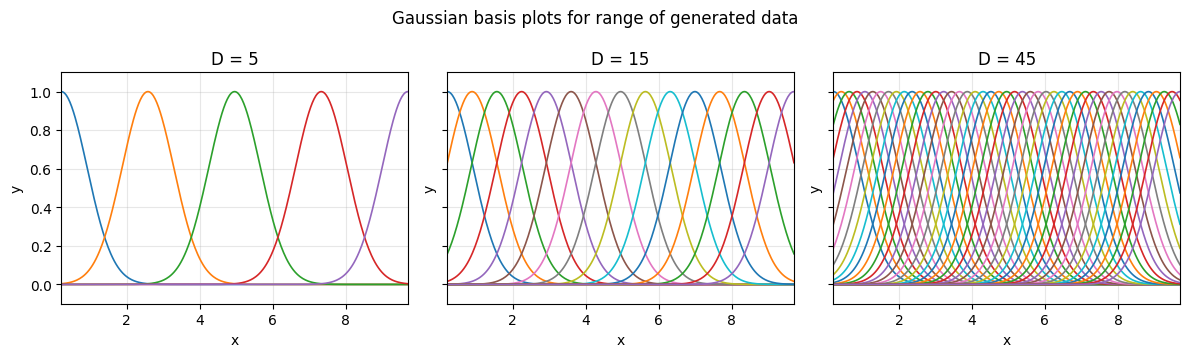

In [70]:
x_dense_for_basis = np.linspace(x_min, x_max, 400)

def plot_basis(ax, D):
    Phi = gaussian_phi(x_dense_for_basis, D)
    for j in range(Phi.shape[1]):
        ax.plot(x_dense_for_basis, Phi[:, j], linewidth=1.2)
    ax.set_title(f'D = {D}')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

fig, axes = plt.subplots(1, 3, figsize=(12, 3.6), sharex=True, sharey=True)
for ax, D in zip(axes, [5, 15, 45]):
    plot_basis(ax, D)

fig.suptitle(f'Gaussian basis plots for range of generated data')
plt.tight_layout()
plt.show()


In [9]:
Ds = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

In [10]:
fits_all = {D: fit_num_bases(D, x, y_noisy) for D in Ds}

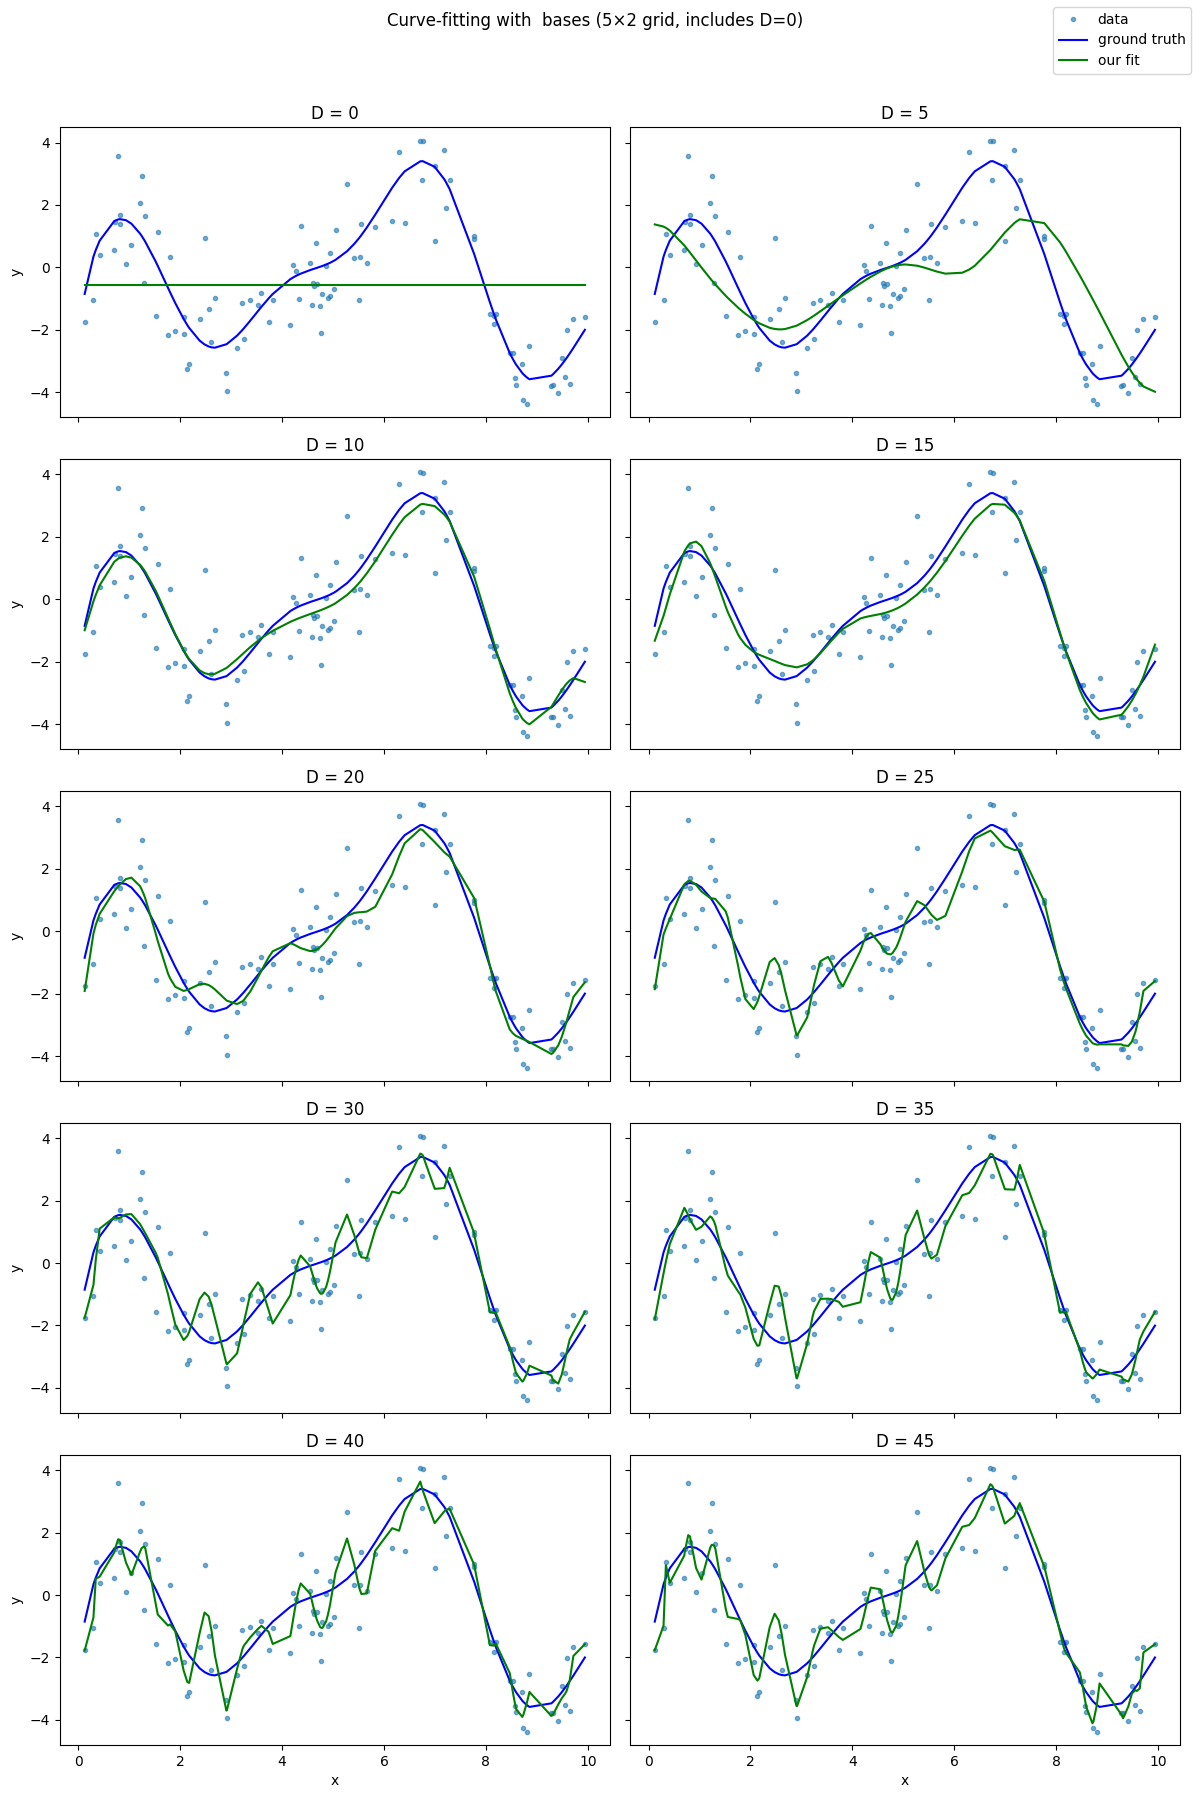

In [11]:
fig, axes = plt.subplots(5, 2, figsize=(12, 18), sharex=True, sharey=True)

for idx, D in enumerate(Ds):
    ax = axes[idx // 2, idx % 2]
    yh = fits_all[D]

    ax.plot(x, y_noisy, '.', alpha=0.6, label='data' if idx == 0 else None)
    ax.plot(x, y_clean, 'b-', label='ground truth' if idx == 0 else None)
    ax.plot(x, yh, 'g-', label='our fit' if idx == 0 else None)
    ax.set_title(f'D = {D}')
    if idx // 2 == 4:
        ax.set_xlabel('x')
    if idx % 2 == 0:
        ax.set_ylabel('y')
handles, labels = axes[0, 0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper right')

fig.suptitle('Curve-fitting with  bases (5×2 grid, includes D=0)', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

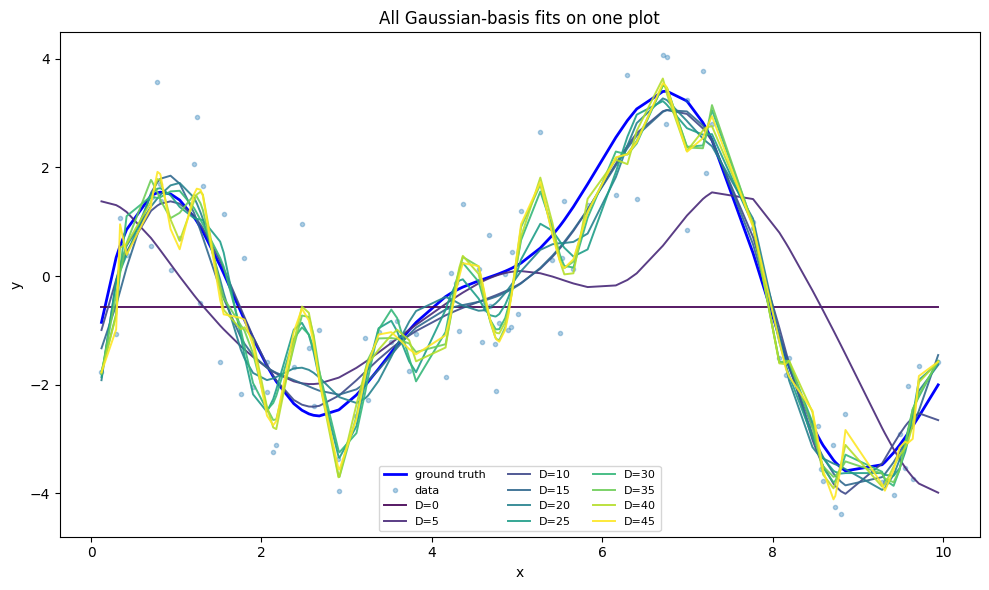

In [12]:
cmap = get_cmap('viridis')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, y_clean, 'b-', lw=2, label='ground truth')
ax.plot(x, y_noisy, '.', alpha=0.35, label='data')

for i, D in enumerate(Ds):
    color = cmap(i / (len(Ds) - 1))
    ax.plot(x, fits_all[D], lw=1.4, alpha=0.9, color=color, label=f'D={D}')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('All Gaussian-basis fits on one plot')
ax.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

In [13]:
def train_val_split(x, y, val_fraction=0.3, random_state=0):
    rng = np.random.RandomState(random_state)
    idx = np.arange(x.shape[0])
    rng.shuffle(idx)
    n_val = int(np.round(val_fraction * x.shape[0]))
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]
    return train_idx, val_idx

In [14]:
train_idx, val_idx = train_val_split(x, y_noisy, val_fraction=0.2, random_state=0)
sse_train, sse_val = [], []
for D in Ds:
    Phi_train = gaussian_phi(x[train_idx], D)
    Phi_val   = gaussian_phi(x[val_idx],  D)
    model.fit(Phi_train, y_noisy[train_idx])
    yh_train = model.predict(Phi_train)
    yh_val   = model.predict(Phi_val)
    sse_train.append(float(np.sum((y_noisy[train_idx] - yh_train) ** 2)))
    sse_val.append(float(np.sum((y_noisy[val_idx]   - yh_val)   ** 2)))

In [15]:
best_idx = int(np.argmin(sse_val))
best_D = Ds[best_idx]

print("D\tSSE_train\t\tSSE_val")
for D, tr, va in zip(Ds, sse_train, sse_val):
    mark = "  <-- best" if D == best_D else ""
    print(f"{D:>2}\t{tr:.6f}\t{va:.6f}{mark}")

print(f"\nBest D (by validation SSE): {best_D}")
print(f"SSE_train, SSE_val at best D: {sse_train[best_idx]} {sse_val[best_idx]}")

D	SSE_train		SSE_val
 0	329.445999	104.317322
 5	230.547452	37.115903
10	82.545655	17.829319
15	75.726915	19.572199
20	71.858087	18.411050
25	62.858995	16.166712  <-- best
30	56.543354	17.050606
35	47.159814	25.278508
40	41.952628	28.903893
45	37.240550	40.564318

Best D (by validation SSE): 25
SSE_train, SSE_val at best D: 62.85899498335965 16.16671222846636


Log scale for visibility

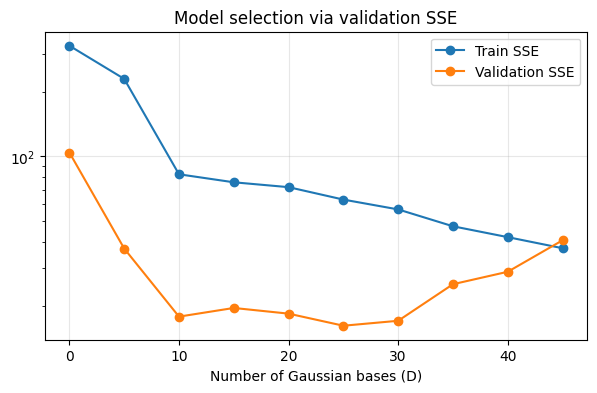

In [16]:
plt.figure(figsize=(7, 4))
plt.plot(Ds, sse_train, marker='o', label='Train SSE')
plt.plot(Ds, sse_val, marker='o', label='Validation SSE')
plt.xlabel('Number of Gaussian bases (D)')
plt.yscale('log')
plt.title('Model selection via validation SSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Task 2 - Bias-Variance Tradeoff with Multiple Fits

In [17]:
R = 10 #repetiton

In [18]:
all_fits = {D: [] for D in Ds}
train_sse = {D: [] for D in Ds}
test_sse  = {D: [] for D in Ds}

train_mse = {D: [] for D in Ds}
test_mse  = {D: [] for D in Ds}

In [19]:
np.random.seed(15)

In [20]:
for r in range(R):
    y_r = y_clean + np.random.randn(n_data)
    tr_idx, te_idx = train_val_split(x, y_r, val_fraction=0.2, random_state=r)

    for D in Ds:
        Phi_tr  = gaussian_phi(x[tr_idx], D)
        Phi_te  = gaussian_phi(x[te_idx], D)
        Phi_all = gaussian_phi(x,        D)

        m = LinearRegression(add_bias=True).fit(Phi_tr, y_r[tr_idx])
        yh_tr  = m.predict(Phi_tr)
        yh_te  = m.predict(Phi_te)
        yh_all = m.predict(Phi_all)

        train_sse[D].append(float(np.sum((y_r[tr_idx] - yh_tr) ** 2)))
        test_sse[D].append(float(np.sum((y_r[te_idx]  - yh_te) ** 2)))
        train_mse[D].append(float(np.mean((y_r[tr_idx] - yh_tr) ** 2)))
        test_mse[D].append(float(np.mean((y_r[te_idx] - yh_te) ** 2)))
        all_fits[D].append(yh_all)

In [21]:
ymin = float(np.min(y_clean))
ymax = float(np.max(y_clean))
pad  = 0.10 * (ymax - ymin)
ylims = (ymin - pad, ymax + pad)

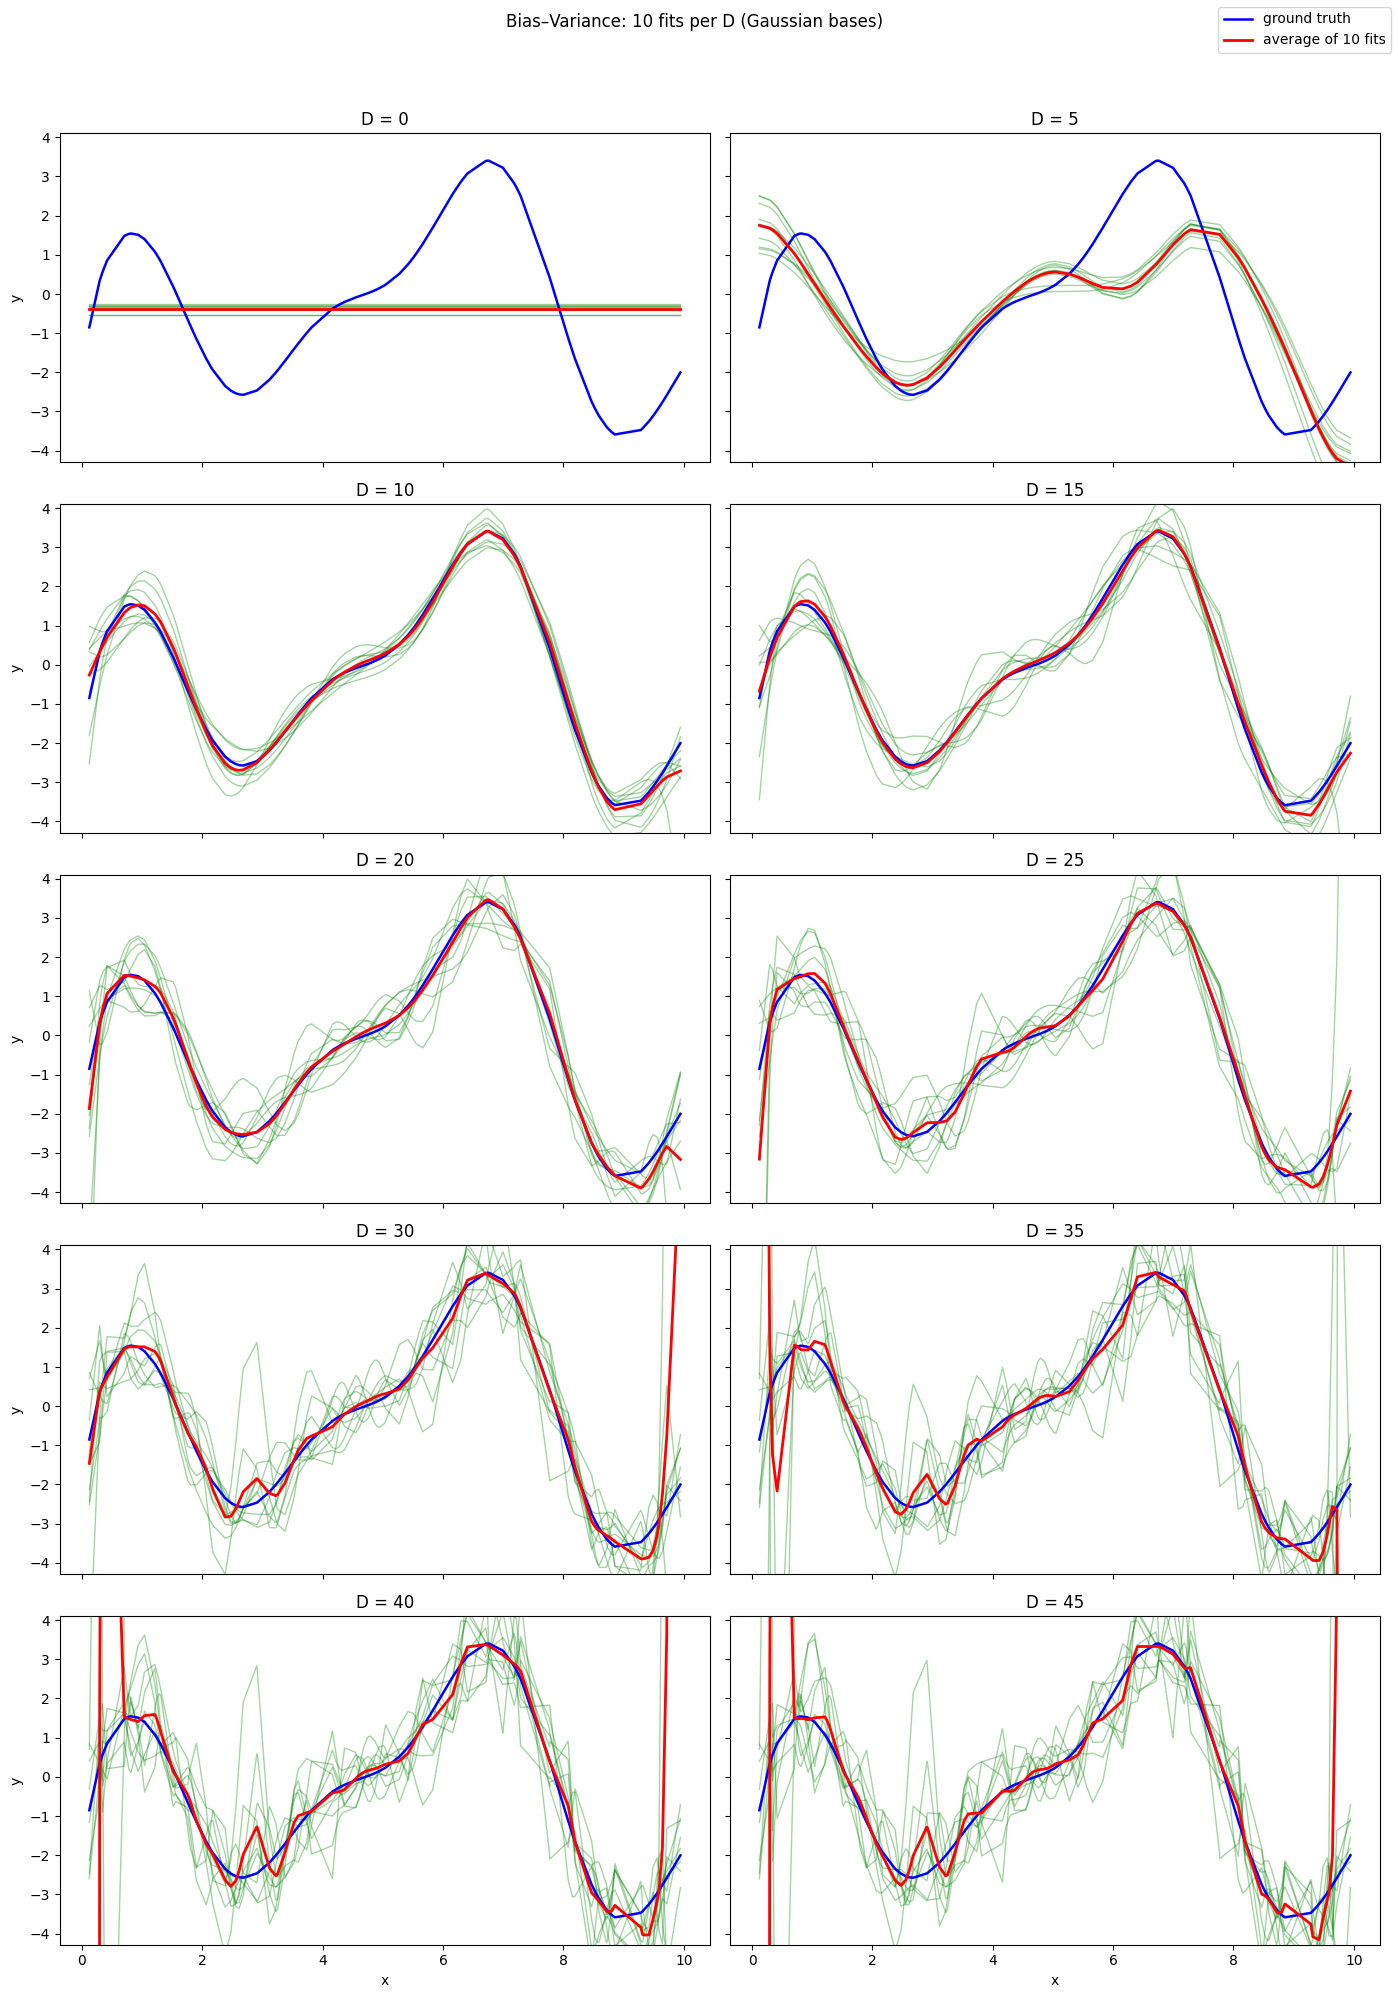

In [22]:
fig, axes = plt.subplots(5, 2, figsize=(14, 20), sharex=True, sharey=True)

for idx, D in enumerate(Ds):
    ax = axes[idx // 2, idx % 2]
    fits = np.column_stack(all_fits[D])      # (N, R)
    mean_fit = np.mean(fits, axis=1)

    for r in range(R):
        ax.plot(x, fits[:, r], color='green', alpha=0.35, linewidth=1)

    ax.plot(x, y_clean, 'b-', linewidth=1.8, label='ground truth' if idx == 0 else None)
    ax.plot(x, mean_fit, 'r-', linewidth=2.0, label='average of 10 fits' if idx == 0 else None)

    ax.set_title(f'D = {D}')
    ax.set_ylim(*ylims)
    if idx // 2 == 4: ax.set_xlabel('x')
    if idx % 2  == 0: ax.set_ylabel('y')

handles, labels = axes[0, 0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper right')
fig.suptitle('Bias–Variance: 10 fits per D (Gaussian bases)', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



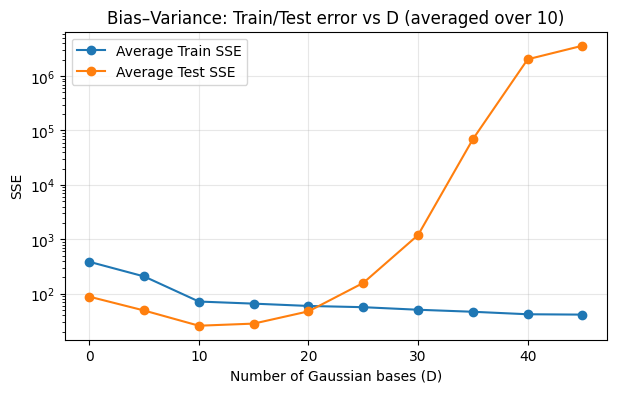

In [23]:
avg_train = np.array([np.mean(train_sse[D]) for D in Ds])
avg_test  = np.array([np.mean(test_sse[D])  for D in Ds])

plt.figure(figsize=(7, 4))
plt.plot(Ds, avg_train, marker='o', label='Average Train SSE')
plt.plot(Ds, avg_test,  marker='o', label='Average Test SSE')
plt.xlabel('Number of Gaussian bases (D)')
plt.ylabel('SSE')
plt.yscale('log')
plt.title('Bias–Variance: Train/Test error vs D (averaged over 10)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

##  Task 3: Regularization with Cross-Validation

In [24]:
def cross_validation(model_type, X, y, lambdas, k=10):
    """
    Perform k-fold cross-validation for L1 or L2 regularization.

    Parameters
    ----------
    model_type : str
        Either 'L1' for Lasso or 'L2' for Ridge.
    X : np.ndarray
        Feature matrix of shape (N, D).
    y : np.ndarray
        Target vector of shape (N,).
    lambdas : list or np.ndarray
        List of regularization strengths to evaluate.
    k : int
        Number of folds (default 10).
    """
    N = X.shape[0]
    if not (2 <= k <= N):
        raise ValueError("k must be in [2, N]")

    indices = np.arange(N)
    np.random.shuffle(indices)
    folds = np.array_split(indices, k)

    mean_train_mse = []
    mean_val_mse = []

    for lam in lambdas:
        train_mse_list = []
        val_mse_list = []

        for i in range(k):
            val_idx = folds[i]
            train_idx = np.concatenate([folds[j] for j in range(k) if j != i])

            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            if model_type == "L1":
                model = LinearRegression(add_bias=True, l1_reg=lam, l2_reg=0)
                model.fit_lasso(X_train, y_train)
            elif model_type == "L2":
                optimizer = GradientDescent(learning_rate=0.01, max_iters=10000)
                model = LinearRegression(add_bias=True, l2_reg=lam, l1_reg=0)
                model.fit_ridge(X_train, y_train, optimizer)
            else:
                raise ValueError("model_type must be 'L1' or 'L2'")

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            train_mse = np.mean((y_train - y_train_pred) ** 2)
            val_mse = np.mean((y_val - y_val_pred) ** 2)

            train_mse_list.append(train_mse)
            val_mse_list.append(val_mse)

        mean_train_mse.append(np.mean(train_mse_list))
        mean_val_mse.append(np.mean(val_mse_list))

    return np.array(mean_train_mse), np.array(mean_val_mse)


In [25]:
# We test the different regularizations

D = 45
phi = gaussian_phi(x, D)

lambdas = np.logspace(-3,1,10)

Original no regularization for base 45

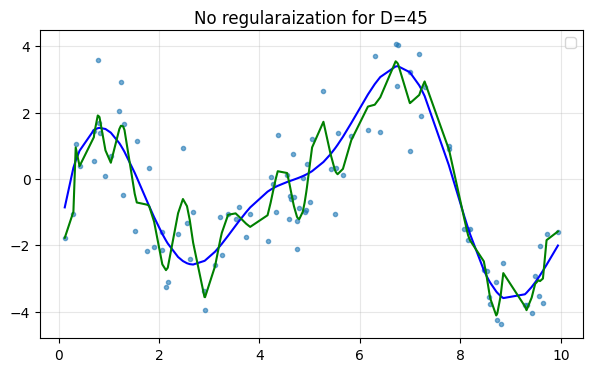

In [26]:
model_noreg = LinearRegression(add_bias=True)
y_noreg = model.fit(phi, y_noisy).predict(phi).reshape(-1)

plt.figure(figsize=(7, 4))
plt.plot(x, y_noisy, '.', alpha=0.6, label='data' if idx == 0 else None)
plt.plot(x, y_clean, 'b-', label='ground truth' if idx == 0 else None)
plt.plot(x, y_noreg, 'g-', label='our fit' if idx == 0 else None)
plt.title('No regularaization for D=45', y=0.995)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**RIDGE**

In [27]:
preds = []
models = []
mses = np.empty(len(lambdas), dtype=float)
for i, lam in enumerate(lambdas):
    #     model = LinearRegression(add_bias=True, l1_reg=lam, l2_reg=0)
    #     model.fit_lasso(X, y)
    optimizer = GradientDescent(learning_rate=0.01, max_iters=10000)
    model = LinearRegression(add_bias=True, l2_reg=lam, l1_reg=0)
    model.fit_ridge(phi, y_noisy, optimizer)
    y_hat = model.predict(phi)
    mses[i] = np.mean((y_noisy - y_hat) ** 2)
    preds.append(y_hat)
    models.append(model)

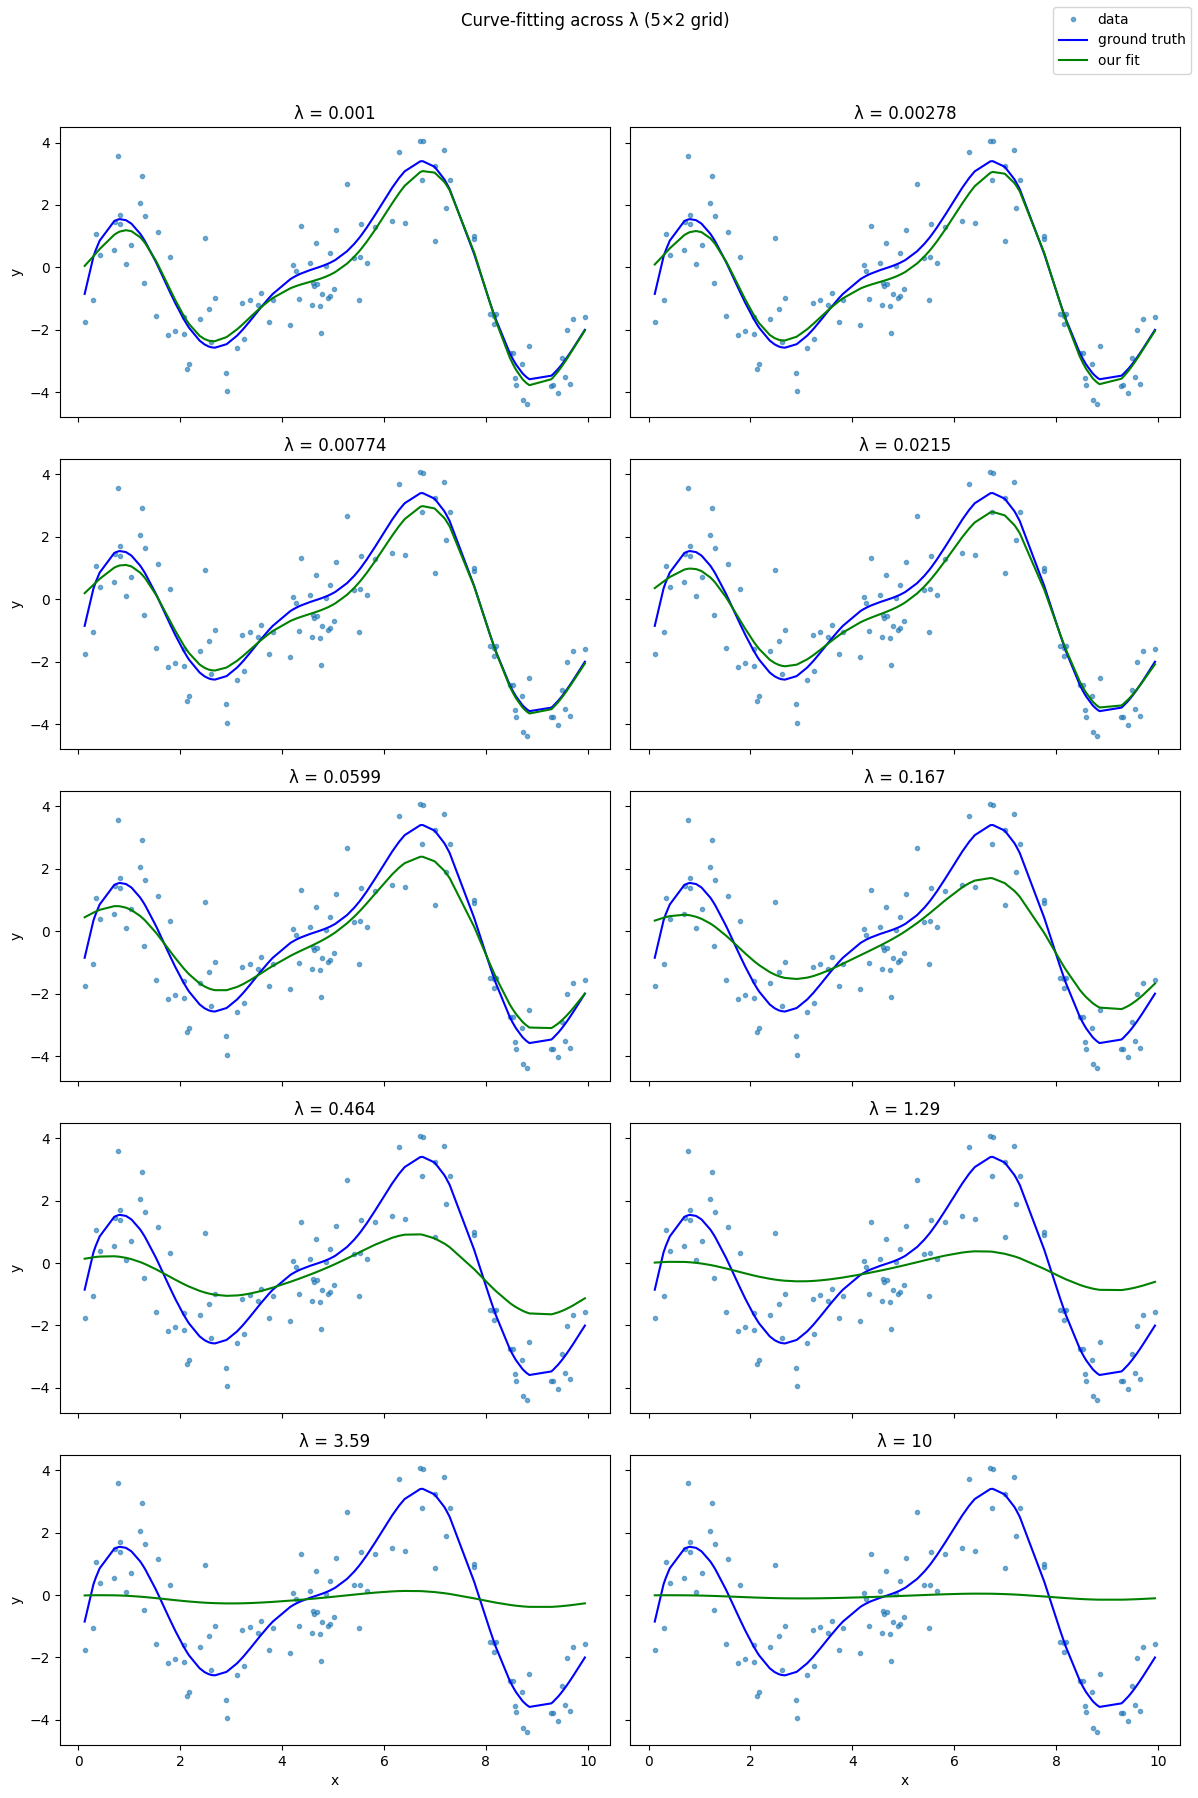

In [28]:
fig, axes = plt.subplots(5, 2, figsize=(12, 18), sharex=True, sharey=True)

for idx, lam in enumerate(lambdas):
    ax = axes[idx // 2, idx % 2]
    yh = preds[idx]

    ax.plot(x, y_noisy, '.', alpha=0.6, label='data' if idx == 0 else None)
    ax.plot(x, y_clean, 'b-', label='ground truth' if idx == 0 else None)
    ax.plot(x, yh, 'g-', label='our fit' if idx == 0 else None)

    ax.set_title(f'λ = {lam:.3g}')
    if idx // 2 == 4:
        ax.set_xlabel('x')
    if idx % 2 == 0:
        ax.set_ylabel('y')

for j in range(len(lambdas), 10):
    axes[j // 2, j % 2].axis('off')

handles, labels = axes[0, 0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper right')

fig.suptitle('Curve-fitting across λ (5×2 grid)', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

**Lasso**

In [29]:
preds = []
models = []
mses = np.empty(len(lambdas), dtype=float)
for i, lam in enumerate(lambdas):
    model = LinearRegression(add_bias=True, l1_reg=lam, l2_reg=0)
    model.fit_lasso(phi, y_noisy)
    y_hat = model.predict(phi)
    mses[i] = np.mean((y_noisy - y_hat) ** 2)
    preds.append(y_hat)
    models.append(model)

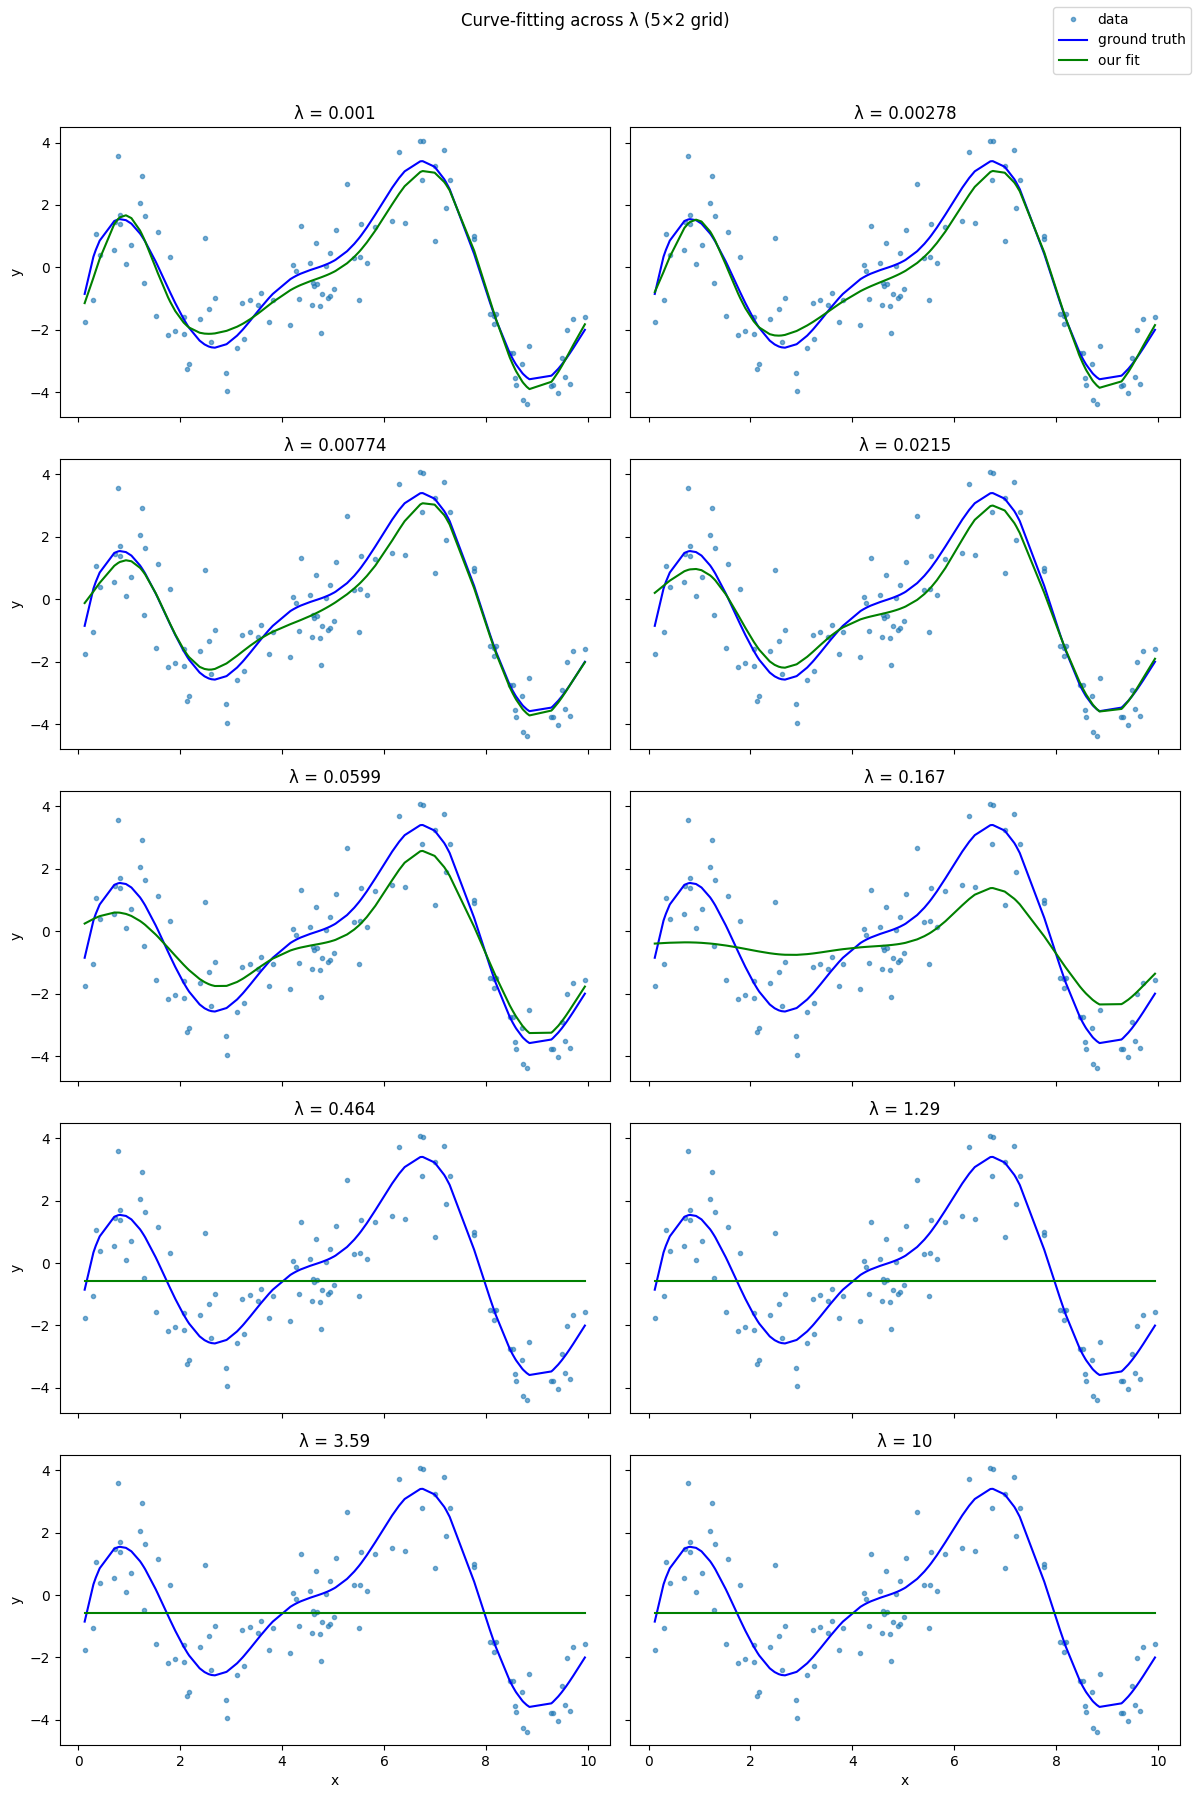

In [30]:
fig, axes = plt.subplots(5, 2, figsize=(12, 18), sharex=True, sharey=True)

for idx, lam in enumerate(lambdas):
    ax = axes[idx // 2, idx % 2]
    yh = preds[idx]

    ax.plot(x, y_noisy, '.', alpha=0.6, label='data' if idx == 0 else None)
    ax.plot(x, y_clean, 'b-', label='ground truth' if idx == 0 else None)
    ax.plot(x, yh, 'g-', label='our fit' if idx == 0 else None)

    ax.set_title(f'λ = {lam:.3g}')
    if idx // 2 == 4:
        ax.set_xlabel('x')
    if idx % 2 == 0:
        ax.set_ylabel('y')

for j in range(len(lambdas), 10):
    axes[j // 2, j % 2].axis('off')

handles, labels = axes[0, 0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper right')

fig.suptitle('Curve-fitting across λ (5×2 grid)', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Find best Lambda

In [31]:
train_mse_L1 , val_mse_L1 = cross_validation("L1", phi, y_noisy, lambdas)
train_mse_L2 , val_mse_L2 = cross_validation("L2", phi, y_noisy, lambdas)

best_lambda_L1 = lambdas[np.nanargmin(val_mse_L1)]
best_lambda_L2 = lambdas[np.nanargmin(val_mse_L2)]

print("Best value of lambda for L1 : ", best_lambda_L1)
print("Best value of lambda for L2 : ", best_lambda_L2)

Best value of lambda for L1 :  0.001
Best value of lambda for L2 :  0.0027825594022071257


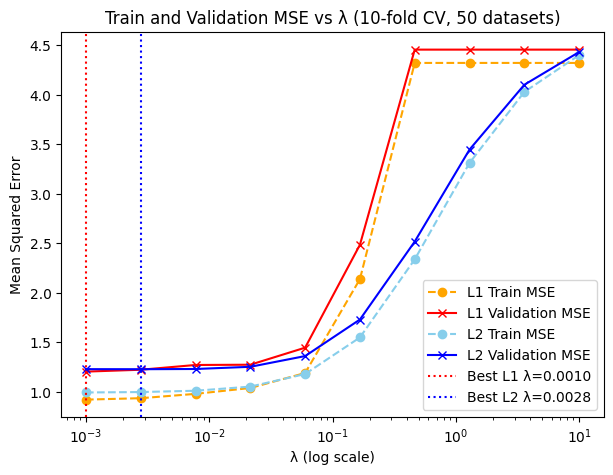

In [32]:
# ---- Plotting ----
plt.figure(figsize=(7,5))
plt.semilogx(lambdas, train_mse_L1, 'o--', label='L1 Train MSE', color='orange')
plt.semilogx(lambdas, val_mse_L1, 'x-', label='L1 Validation MSE', color='red')
plt.semilogx(lambdas, train_mse_L2, 'o--', label='L2 Train MSE', color='skyblue')
plt.semilogx(lambdas, val_mse_L2, 'x-', label='L2 Validation MSE', color='blue')

plt.axvline(best_lambda_L1, color='red', linestyle=':', label=f'Best L1 λ={best_lambda_L1:.4f}')
plt.axvline(best_lambda_L2, color='blue', linestyle=':', label=f'Best L2 λ={best_lambda_L2:.4f}')

plt.title("Train and Validation MSE vs λ (10-fold CV, 50 datasets)")
plt.xlabel("λ (log scale)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

In [33]:
# Make a function that extracts variance and bias for each value of lambda
def bias_variance_decomposition(reg_type, phi, y_true, lambdas, num_datasets=50, noise_var=1.0):
    """
    Compatible with LinearRegression class (fit_lasso, fit_ridge)
    Computes Bias², Variance, and total error for each lambda.
    """
    N, D = phi.shape
    bias2_list, var_list, total_error_list = [], [], []

    for lmbda in lambdas:
        preds = []

        for _ in range(num_datasets):
            # Generate noisy dataset
            noise = np.random.normal(0, np.sqrt(noise_var), size=y_true.shape)
            y_noisy = y_true + noise

            model = LinearRegression(add_bias=False, l1_reg=lmbda if reg_type == "L1" else 0, l2_reg=lmbda if reg_type == "L2" else 0)

            if reg_type == "L1":
                model.fit_lasso(phi, y_noisy)
            elif reg_type == "L2":
                # Gradient descent optimizer for ridge
                optimizer = GradientDescent(learning_rate=0.001, max_iters=1e4)
                model.fit_ridge(phi, y_noisy, optimizer)
            else:
                raise ValueError("reg_type must be 'L1' or 'L2'")

            preds.append(model.predict(phi))

        preds = np.array(preds)
        mean_pred = np.mean(preds, axis=0)

        # Bias² = mean over samples of (mean_pred - true_y)^2
        bias2 = np.mean((mean_pred - y_true) ** 2)

        # Variance = mean of variance of predictions
        var = np.mean(np.var(preds, axis=0))

        # Total error (theoretical expectation)
        total_error = bias2 + var + noise_var

        bias2_list.append(bias2)
        var_list.append(var)
        total_error_list.append(total_error)

    return np.array(bias2_list), np.array(var_list), np.array(total_error_list)

In [34]:
# Extracting bias and variance for each regularization mode
bias2_L1, var_L1, total_error_L1 = bias_variance_decomposition("L1", phi, y_noisy, lambdas)
bias2_L2, var_L2, total_error_L2 = bias_variance_decomposition("L2", phi, y_noisy, lambdas)

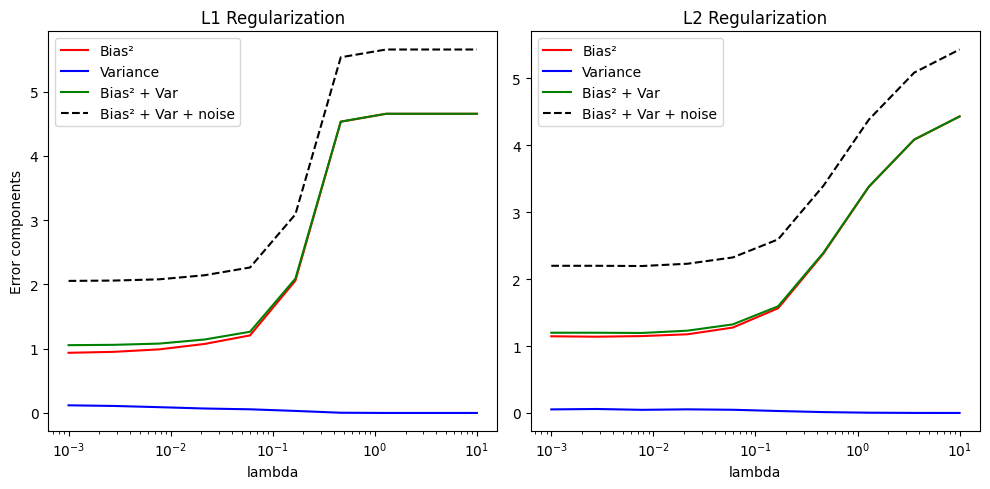

In [35]:
# ---- Plotting ----
plt.figure(figsize=(10,5))

# L1
plt.subplot(1,2,1)
plt.semilogx(lambdas, bias2_L1, 'r-', label='Bias²')
plt.semilogx(lambdas, var_L1, 'b-', label='Variance')
plt.semilogx(lambdas, bias2_L1 + var_L1, 'g-', label='Bias² + Var')
plt.semilogx(lambdas, total_error_L1, 'k--', label='Bias² + Var + noise')
plt.title("L1 Regularization")
plt.xlabel("lambda")
plt.ylabel("Error components")
plt.legend()

# L2
plt.subplot(1,2,2)
plt.semilogx(lambdas, bias2_L2, 'r-', label='Bias²')
plt.semilogx(lambdas, var_L2, 'b-', label='Variance')
plt.semilogx(lambdas, bias2_L2 + var_L2, 'g-', label='Bias² + Var')
plt.semilogx(lambdas, total_error_L2, 'k--', label='Bias² + Var + noise')
plt.title("L2 Regularization")
plt.xlabel("lambda")
plt.legend()

plt.tight_layout()
plt.show()


In [36]:
# Integration of kfold logic in the bias variance study

def bias_variance_decomposition_kfold(reg_type, phi, y_noisy, lambdas, num_datasets=50, noise_var=1.0, k=5):
    """
    Bias-Variance decomposition with k-fold cross-validation.
    reg_type: "L1" or "L2"
    phi: design matrix
    y_true: true targets
    lambdas: list of regularization strengths
    num_datasets: number of noisy datasets to average over
    noise_var: variance of noise
    k: number of folds for cross-validation
    """
    N, D = phi.shape
    bias2_list, var_list, total_error_list = [], [], []
    indices = np.arange(N)

    for lmbda in lambdas:
        preds = np.zeros((num_datasets, N))

        for dset_idx in range(num_datasets):
            folds = np.array_split(indices, k)
            fold_preds = np.zeros(N)

            for i in range(k):
                test_idx = folds[i]
                train_idx = np.setdiff1d(indices, test_idx)

                X_train, X_test = phi[train_idx], phi[test_idx]
                y_train = y_noisy[train_idx]

                model = LinearRegression(
                    add_bias=False,
                    l1_reg=lmbda if reg_type=="L1" else 0,
                    l2_reg=lmbda if reg_type=="L2" else 0
                )

                if reg_type=="L1":
                    model.fit_lasso(X_train, y_train)
                elif reg_type=="L2":
                    optimizer = GradientDescent(learning_rate=0.001, max_iters=1e4)
                    model.fit_ridge(X_train, y_train, optimizer)

                fold_preds[test_idx] = model.predict(X_test)

            preds[dset_idx] = fold_preds

        # Bias and variance
        mean_pred = np.mean(preds, axis=0)
        bias2 = np.mean((mean_pred - y_noisy)**2)
        var = np.mean(np.var(preds, axis=0))
        total_error = bias2 + var + noise_var

        bias2_list.append(bias2)
        var_list.append(var)
        total_error_list.append(total_error)

    return np.array(bias2_list), np.array(var_list), np.array(total_error_list)

In [37]:
def bias_variance_kfold(reg_type, phi, y_noisy, lambdas, num_datasets=50, k=5):
    """
    Compute Bias², Variance and Total Error with k-fold CV.
    """
    N = phi.shape[0]
    bias2_list, var_list, total_error_list = [], [], []
    indices = np.arange(N)

    for lmbda in lambdas:
        preds = np.zeros((num_datasets, N))

        for d in range(num_datasets):
            folds = np.array_split(indices, k)
            fold_preds = np.zeros(N)

            for i in range(k):
                test_idx = folds[i]
                train_idx = np.setdiff1d(indices, test_idx)
                X_train, X_test = phi[train_idx], phi[test_idx]
                y_train = y_noisy[train_idx]

                model = LinearRegression(
                    add_bias=False,
                    l1_reg=lmbda if reg_type=="L1" else 0,
                    l2_reg=lmbda if reg_type=="L2" else 0
                )

                if reg_type=="L1":
                    model.fit_lasso(X_train, y_train)
                else:
                    optimizer = GradientDescent(learning_rate=0.001, max_iters=1e4)
                    model.fit_ridge(X_train, y_train, optimizer)

                fold_preds[test_idx] = model.predict(X_test)

            preds[d] = fold_preds

        mean_pred = np.mean(preds, axis=0)
        bias2 = np.mean((mean_pred - y_noisy)**2)      # compare to samples
        var = np.mean(np.var(preds, axis=0))
        total_error = bias2 + var
        bias2_list.append(bias2)
        var_list.append(var)
        total_error_list.append(total_error)

    return np.array(bias2_list), np.array(var_list), np.array(total_error_list)

In [38]:
# kfold logic implementation on L1 L2 Reg
lambdas = np.logspace(-3, 1, 10)
k = 5

bias2_L1, var_L1, total_error_L1 = bias_variance_kfold("L1", phi, y_noisy, lambdas, num_datasets=10, k=k)
bias2_L2, var_L2, total_error_L2 = bias_variance_kfold("L2", phi, y_noisy, lambdas, num_datasets=10, k=k)

# Task 4 - Effect of L1 and L2 on Loss

In [39]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of data points
n_points = 30

# Generate x uniformly between 0 and 10
x = np.random.uniform(0, 10, n_points)

# Generate Gaussian noise (mean 0, variance 1)
epsilon = np.random.normal(0, 1, n_points)

def generate_data_linear(x, epsilon):
  y = -3*x + 8 + epsilon
  return y

y_clean_linear = generate_data_linear(x, 0)
y_noisy_linear = generate_data_linear(x, epsilon)

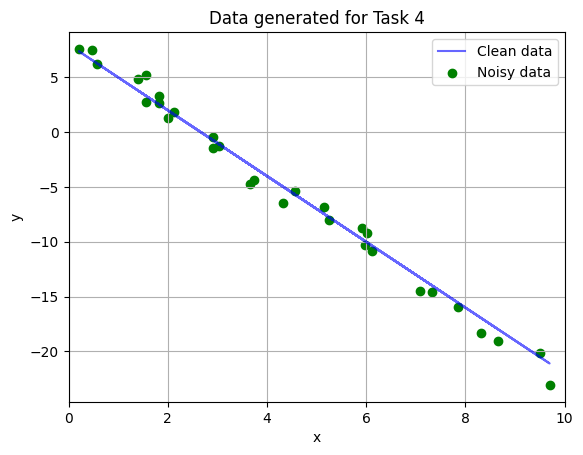

In [40]:
# Plot the true distribution vs the noisy dist
plt.plot(x, y_clean_linear, label="Clean data", alpha=0.6, color="blue")
plt.scatter(x, y_noisy_linear, label='Noisy data', color="green")
plt.legend()
plt.xlim(0,10)
plt.grid(True)
plt.title("Data generated for Task 4")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Slope and Intercept obtained by L1 reg. :  [-3.13917769  8.42840019]
Slope and Intercept obtained by L2 reg. :  [-3.12897627  8.36692318]


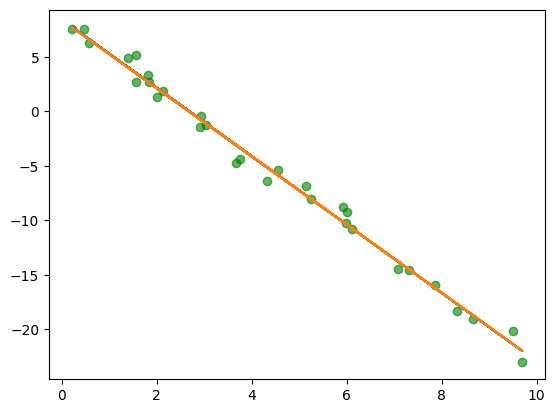

In [41]:
# Apply model on this equation

model_linear_L1 = LinearRegression(add_bias=True, l1_reg=0.001)
model_linear_L2 = LinearRegression(add_bias=True, l2_reg=0.001)

model_linear_L1.fit_lasso(x,y_noisy_linear)
model_linear_L2.fit_ridge(x,y_noisy_linear, GradientDescent(learning_rate=0.01, max_iters=100000))

y_pred_linear_L1 = model_linear_L1.predict(x)
y_pred_linear_L2 = model_linear_L2.predict(x)

# Results
print("Slope and Intercept obtained by L1 reg. : ", model_linear_L1.w)
print("Slope and Intercept obtained by L2 reg. : ", model_linear_L2.w)

plt.scatter(x,y_noisy_linear, alpha=0.6, color="green")
plt.plot(x,y_pred_linear_L1)
plt.plot(x,y_pred_linear_L2)
plt.show()

In [42]:
# Plotting the loss versus different regularization

def ridge_loss(w, l2_reg=0.1, x=x, y=y_noisy_linear):
    y_pred = w[0]*x + w[1]
    return np.mean((y - y_pred)**2) + l2_reg * (w[0]**2 + w[1]**2)

def lasso_loss(w, l1_reg=0.1, x=x, y=y_noisy_linear):
    y_pred = w[0]*x + w[1]
    mse = np.mean((y - y_pred)**2)
    l1_penalty = l1_reg * (np.abs(w[0]) + np.abs(w[1]))
    return mse + l1_penalty


def plot_contour(x, y, loss_fn, w0_range=(-5, 0), w1_range=(0, 10), resolution=100, title="Loss contour"):
    """
    Trace contour plots while varying w0 and w1
    loss_fn: loss function to report performance of different w0, w1
    """
    w0_vals = np.linspace(*w0_range, resolution)
    w1_vals = np.linspace(*w1_range, resolution)
    W0, W1 = np.meshgrid(w0_vals, w1_vals)
    Loss = np.zeros_like(W0)

    for i in range(resolution):
        for j in range(resolution):
            w = np.array([W0[i,j], W1[i,j]])
            Loss[i,j] = loss_fn(w)

    plt.figure(figsize=(6,5))
    cp = plt.contour(W0, W1, Loss, levels=20, cmap='viridis')
    plt.clabel(cp, inline=0, fontsize=10)
    plt.xlabel("w0 (slope)")
    plt.ylabel("w1 (intercept)")
    plt.title(title)
    plt.show()

Ridge L2, l2=0.001 => w0=-3.1290, w1=8.3669
Ridge L2, l2=0.01 => w0=-3.0421, w1=7.8459
Ridge L2, l2=0.1 => w0=-2.5285, w1=4.7917
Ridge L2, l2=1.0 => w0=-1.7670, w1=0.8033


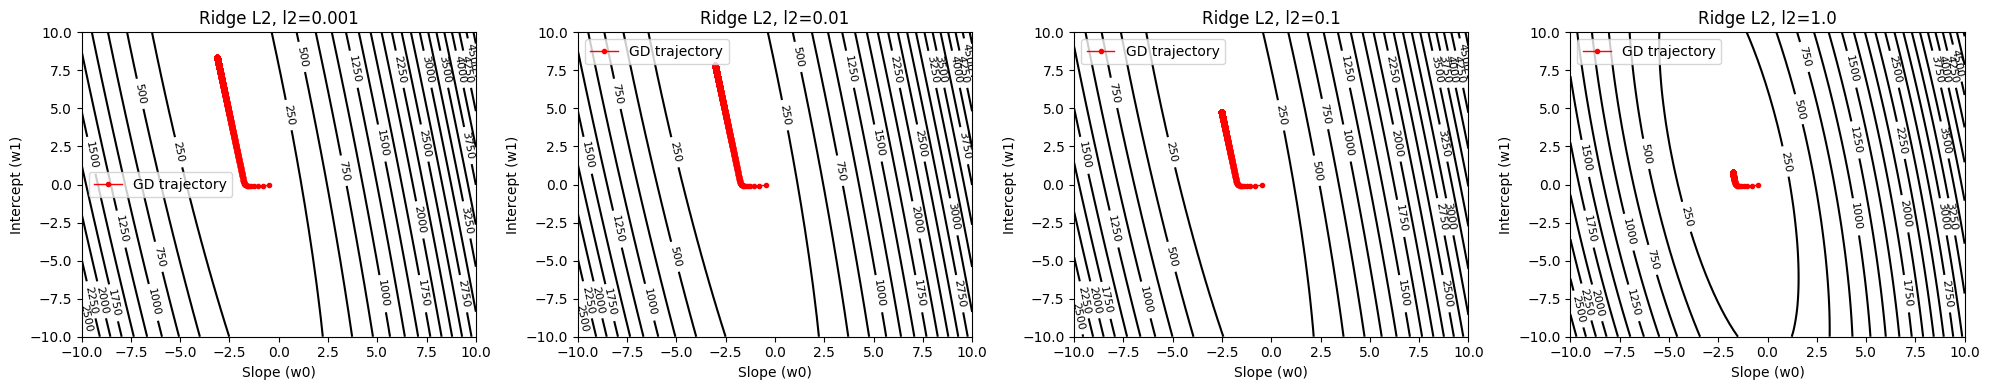

Lasso L1, l1=0.001 => w0=-3.1386, w1=8.4249
Lasso L1, l1=0.01 => w0=-3.1323, w1=8.3883
Lasso L1, l1=0.1 => w0=-3.0694, w1=8.0226
Lasso L1, l1=1.0 => w0=-2.4407, w1=4.3649


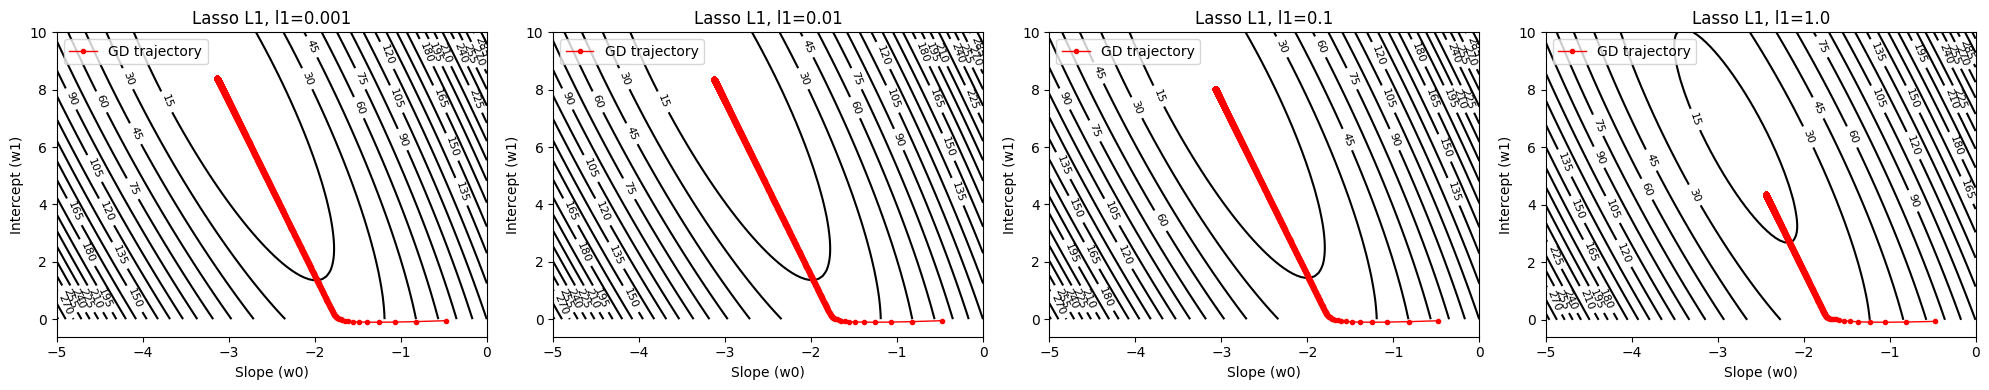

In [43]:
# Example: Ridge and Lasso with multiple strengths
l2_values = [0.001, 0.01, 0.1, 1.0]
l1_values = [0.001, 0.01, 0.1, 1.0]

# Lists to keep the trajectories
ridge_trajectories = []
lasso_trajectories = []

# --- Ridge (L2) with GD trajectory ---
fig, axes = plt.subplots(1, len(l2_values), figsize=(5*len(l2_values),4))
for idx, l2 in enumerate(l2_values):
    def ridge_loss_fn(w, l2_reg=l2, x=x, y=y_noisy_linear):
        y_pred = w[0]*x + w[1]
        return np.mean((y - y_pred)**2) + l2_reg * (w[0]**2 + w[1]**2)

    def ridge_grad(x_, y_, w_, l2_reg=l2):
        y_pred = w_[0]*x_ + w_[1]
        grad_w0 = np.mean((y_pred - y_)*x_) + 2*l2_reg*w_[0]
        grad_w1 = np.mean(y_pred - y_) + 2*l2_reg*w_[1]
        return np.array([grad_w0, grad_w1])

    # Computing contour
    w0_vals = np.linspace(-10,10,100)
    w1_vals = np.linspace(-10,10,100)
    W0, W1 = np.meshgrid(w0_vals, w1_vals)
    Loss = np.zeros_like(W0)
    for i in range(W0.shape[0]):
        for j in range(W0.shape[1]):
            Loss[i,j] = ridge_loss_fn([W0[i,j], W1[i,j]])

    # Trace contour
    ax = axes[idx]
    cp = ax.contour(W0, W1, Loss, levels=20, colors='black')
    ax.clabel(cp, inline=True, fontsize=8)

    # Gradient descent
    gd = GradientDescent(learning_rate=0.01, record_history=True)
    w_init = np.array([0.0, 0.0])
    optimal_w = gd.run(ridge_grad, x, y_noisy_linear, w_init)
    traj = np.array(gd.w_history)

    ridge_trajectories.append(traj)

    # Trace trajectory
    ax.plot(traj[:,0], traj[:,1], 'r-o', markersize=3, linewidth=1, label='GD trajectory')
    ax.set_xlabel("Slope (w0)")
    ax.set_ylabel("Intercept (w1)")
    ax.set_title(f"Ridge L2, l2={l2}")
    ax.legend()

    # Print final results
    print(f"Ridge L2, l2={l2} => w0={optimal_w[0]:.4f}, w1={optimal_w[1]:.4f}")

plt.tight_layout()
plt.show()

# --- Lasso (L1) with GD trajectory ---
fig, axes = plt.subplots(1, len(l1_values), figsize=(5*len(l1_values),4))
for idx, l1 in enumerate(l1_values):
    def lasso_loss_fn(w, l1_reg=l1, x=x, y=y_noisy_linear):
        y_pred = w[0]*x + w[1]
        mse = np.mean((y - y_pred)**2)
        l1_penalty = l1_reg * (np.abs(w[0]) + np.abs(w[1]))
        return mse + l1_penalty

    def lasso_grad(x_, y_, w_, l1_reg=l1):
        y_pred = w_[0]*x_ + w_[1]
        grad_w0 = np.mean((y_pred - y_)*x_) + l1_reg*np.sign(w_[0])
        grad_w1 = np.mean(y_pred - y_) + l1_reg*np.sign(w_[1])
        return np.array([grad_w0, grad_w1])

    # Computing contour
    w0_vals = np.linspace(-5,0,100)
    w1_vals = np.linspace(0,10,100)
    W0, W1 = np.meshgrid(w0_vals, w1_vals)
    Loss = np.zeros_like(W0)
    for i in range(W0.shape[0]):
        for j in range(W0.shape[1]):
            Loss[i,j] = lasso_loss_fn([W0[i,j], W1[i,j]])

    # Trace contour
    ax = axes[idx]
    cp = ax.contour(W0, W1, Loss, levels=20, colors='black')
    ax.clabel(cp, inline=True, fontsize=8)

    # Gradient descent
    gd = GradientDescent(learning_rate=0.01, record_history=True)
    w_init = np.array([0.0, 0.0])
    optimal_w = gd.run(lasso_grad, x, y_noisy_linear, w_init)
    traj = np.array(gd.w_history)

    lasso_trajectories.append(traj)

    # Trace trajectory
    ax.plot(traj[:,0], traj[:,1], 'r-o', markersize=3, linewidth=1, label='GD trajectory')
    ax.set_xlabel("Slope (w0)")
    ax.set_ylabel("Intercept (w1)")
    ax.set_title(f"Lasso L1, l1={l1}")
    ax.legend()

    # Print final results
    print(f"Lasso L1, l1={l1} => w0={optimal_w[0]:.4f}, w1={optimal_w[1]:.4f}")

plt.tight_layout()
plt.show()

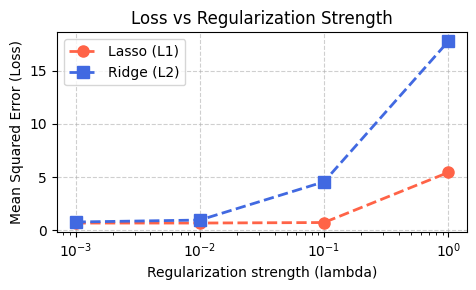

In [44]:
# Computing of the loss for each regularization scenarios

def evaluate_loss(x, y, w0, w1):
    y_pred = w0 * x + w1
    return np.mean((y - y_pred)**2)

# Storing loss values
ridge_loss_values = []
lasso_loss_values = []

# Lasso L1, l1=0.001 => w0=-3.1386, w1=8.4249
lasso_loss_values.append(evaluate_loss(x,y_noisy_linear, -3.1386, 8.4249))
# Lasso L1, l1=0.01 => w0=-3.1323, w1=8.3883
lasso_loss_values.append(evaluate_loss(x,y_noisy_linear, -3.1323, 8.3883))
# Lasso L1, l1=0.1 => w0=-3.0694, w1=8.0226
lasso_loss_values.append(evaluate_loss(x,y_noisy_linear, -3.0694, 8.0226))
# Lasso L1, l1=1.0 => w0=-2.4407, w1=4.3649
lasso_loss_values.append(evaluate_loss(x,y_noisy_linear, -2.4407, 4.3649))

# Ridge L2, l2=0.001 => w0=-3.0431, w1=7.8451
ridge_loss_values.append(evaluate_loss(x,y_noisy_linear, -3.0431, 7.8451))
# Ridge L2, l2=0.01 => w0=-2.9748, w1=7.4364
ridge_loss_values.append(evaluate_loss(x,y_noisy_linear, -2.9748, 7.4364))
# Ridge L2, l2=0.1 => w0=-2.5216, w1=4.7497
ridge_loss_values.append(evaluate_loss(x,y_noisy_linear, -2.5216, 4.7497))
# Ridge L2, l2=1.0 => w0=-1.7670, w1=0.8033
ridge_loss_values.append(evaluate_loss(x,y_noisy_linear, -1.7670, 0.8033))

# Plot
plt.figure(figsize=(5,3))
plt.plot(l1_values, lasso_loss_values, 'o--', color='tomato', linewidth=2, markersize=8, label='Lasso (L1)')
plt.plot(l2_values, ridge_loss_values, 's--', color='royalblue', linewidth=2, markersize=8, label='Ridge (L2)')

plt.xscale('log')
plt.xlabel('Regularization strength (lambda)')
plt.ylabel('Mean Squared Error (Loss)')
plt.title('Loss vs Regularization Strength')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()